# Implementing CIFAR10 using deep learning

In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True
import os

# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

plane ship frog frog  car ship frog


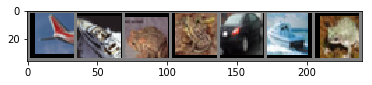

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# # show images
imshow(torchvision.utils.make_grid(images[0:7],nrow = 8))
# print labels
print(''.join('%5s' % classes[labels[j]] for j in range(7)))

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. After taking suggestions from comments on Piazza, I tried implementing VGG.
* After Implementing different VGG Networks, VGG13 gave the best results. 
* I modified the original network to increase accuracy from 80 to 83 percent. This was due to changing the activation function and using dropouts.


In [4]:
# Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv = self._make_layers(config[vgg_name])
        self.linear = self._make_layers_linear()

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def vis(self, x):
        out = self.conv(x)
        return out
    
    def swish(self,x):
        return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

    def _make_layers(self, config):
        layers = []
        in_channels = 3
        for x in config:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
            elif x == 'D':
                layers+= [nn.Dropout(0.5)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
                                                                               # To presever spatial dimension. 
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]#inplace=True, PReLU()
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _make_layers_linear(self):
        layers = []
#         layers +=[nn.Linear(512, 256)]
#         layers+= [nn.Dropout(0.5)]
        layers += [nn.Linear(512, 10)]
#         layers += [nn.LogSoftmax()]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers) # Try softmax here

net = VGG('VGG13')
net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
torch.backends.cudnn.benchmark = True


In [ ]:
net

DataParallel(
  (module): VGG(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [ ]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]           1,792
       BatchNorm2d-3           [-1, 64, 32, 32]             128
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

## Explanations for Network Architecture

* The Loss function used is cross entropy class as there are multiple classes (5)
* The model architecture adopted was that of VGG 13. This is because: 
     * the accuracy was in the range of 64 – 71 percent with a 5 layer network (input – conv1 – conv2- linear - crossentropyloss) .
    * Convolutions were used as the input is 2D images. 
    * Even after adding dropouts of 0.2 and 0.5 in between the convolution layers the accuracy did not improve.
     * Conclusion: as the networks needs to learn RGB images and distinguish 5 labels, it will need more parameters to shatter the input space.  Also the images are very blurry, this adds on to the number of parameters needed as differentiating becomes more difficult.
* VGG 11 also did not give accuracies above 75 percent. As I was able to get descent accuracy with Vgg 13, I did not experiment with this network.
* The Optimizer with Vgg13 is taken as Adam, as it got me better accuracies than SGD. This may be because Adam is able to avoid local minima and does not get stuck. 
* Learning rate of 0.002 gets me a good error convergence graph. Increase the learning rate to 0.01 also gives similar results much faster, but then convergence graph is like a step function and therefore avoided.
* Some other experimentation with dropouts and different activations like (swish, relu and Prelu) can be seen in the screen shot of the excel file I made in the Ipython Notebook.
* Each filter or weights of the convolution layers is visualized, in the image shown below.
    * The image is a representation of weights of the first kernel in each layer (only a depth size of 3 is visualized for each convolution layer)
    * we can see that the weights initialized is different for each layer. ( as they have different colors).


## Visualizaing Weights

In [ ]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0:3])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Showing the weights of the first kernel in each convolution layer
(64, 3, 3, 3)


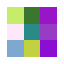

(64, 64, 3, 3)


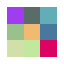

(128, 64, 3, 3)


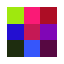

(128, 128, 3, 3)


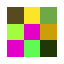

(256, 128, 3, 3)


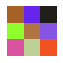

(256, 256, 3, 3)


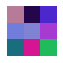

(512, 256, 3, 3)


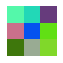

(512, 512, 3, 3)


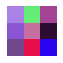

(512, 512, 3, 3)


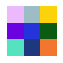

(512, 512, 3, 3)


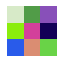

In [ ]:
visnet = VGG('VGG13')
visnet = visnet.to('cpu').double()
print("Showing the weights of the first kernel in each convolution layer")
for m in visnet.modules():
    if isinstance(m, nn.Conv2d):   
        a = m.weight.data.numpy()
#         print(tensor.max())
        c = (a - np.min(a))/np.ptp(a).astype(float)
        print(c.shape)
        plot_kernels(c)
#         break


##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below or attached with homework sumission.
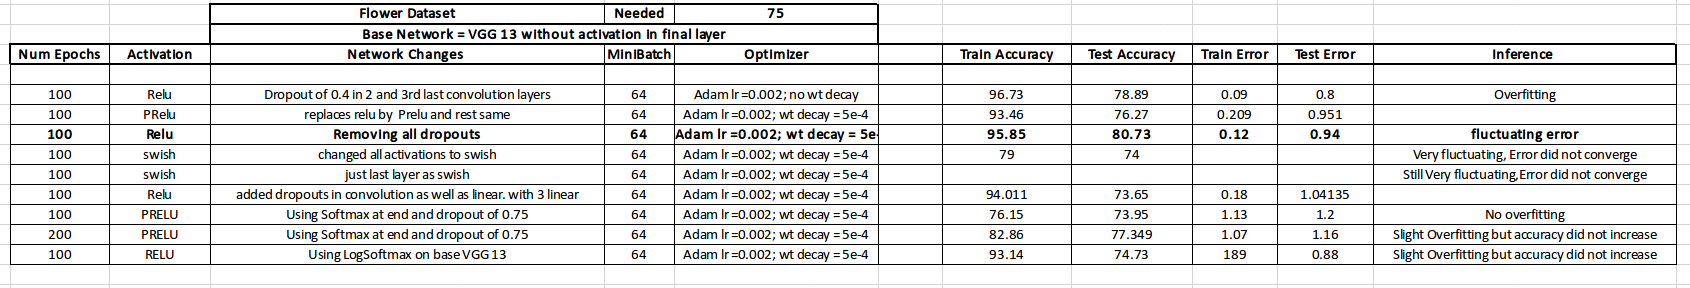
* After all the experimentation, the original vgg 13 network worked the best. Adding dropouts did not help, I guess this is due to not adding them at the right position. I also tried increasing the fully connected layers but it did not help.
* The most significant discrepancy was found that, when not using softmax layer or log softmax layer, the testing accuracy actually came out to be more. I dont know why this happened!!! 

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
# optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]
best_acc= 0  # best test accuracy


In [ ]:
device

'cuda'

In [ ]:
# # For Debugging
# for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target)
#     loss.backward()
#     optimizer.step()
#     break
# # target

## Training and Testing Functions

In [ ]:
def train(model, train_loader, optimizer, epoch,device):
#     print(criterion)
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    global best_acc
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Save checkpoint.
    acc = 100.*correct/len(test_loader.dataset)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
    best_acc = acc

In [ ]:
device

'cuda'

# Training the Model

In [ ]:
start_epoch = 0 # start from epoch 0 or last checkpoint epoch
for epoch in range(start_epoch, start_epoch+500):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.322036
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.010120
Train Epoch: 0 [5120/50000 (10%)]	Loss: 1.837193
Train Epoch: 0 [7680/50000 (15%)]	Loss: 1.752292
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.743335
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.561639
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.607930
Train Epoch: 0 [17920/50000 (36%)]	Loss: 1.616215
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.409737
Train Epoch: 0 [23040/50000 (46%)]	Loss: 1.351524
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.377030
Train Epoch: 0 [28160/50000 (56%)]	Loss: 1.429519
Train Epoch: 0 [30720/50000 (61%)]	Loss: 1.368997
Train Epoch: 0 [33280/50000 (66%)]	Loss: 1.340223
Train Epoch: 0 [35840/50000 (72%)]	Loss: 1.464949
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.290168
Train Epoch: 0 [40960/50000 (82%)]	Loss: 1.335636
Train Epoch: 0 [43520/50000 (87%)]	Loss: 1.124704
Train Epoch: 0 [46080/50000 (92%)]	Loss: 1.180433
Train Epoch: 0 [48640/50000 (97%)]	Loss: 1.201848

Test set

Train Epoch: 7 [40960/50000 (82%)]	Loss: 0.475687
Train Epoch: 7 [43520/50000 (87%)]	Loss: 0.469169
Train Epoch: 7 [46080/50000 (92%)]	Loss: 0.518048
Train Epoch: 7 [48640/50000 (97%)]	Loss: 0.397217

Test set: Average loss: 0.6379, Accuracy: 7809/10000 (78%)

Saving..
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.722174
Train Epoch: 8 [2560/50000 (5%)]	Loss: 0.563061
Train Epoch: 8 [5120/50000 (10%)]	Loss: 0.487654
Train Epoch: 8 [7680/50000 (15%)]	Loss: 0.438528
Train Epoch: 8 [10240/50000 (20%)]	Loss: 0.483296
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.548725
Train Epoch: 8 [15360/50000 (31%)]	Loss: 0.446596
Train Epoch: 8 [17920/50000 (36%)]	Loss: 0.526320
Train Epoch: 8 [20480/50000 (41%)]	Loss: 0.552107
Train Epoch: 8 [23040/50000 (46%)]	Loss: 0.623903
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.487808
Train Epoch: 8 [28160/50000 (56%)]	Loss: 0.538544
Train Epoch: 8 [30720/50000 (61%)]	Loss: 0.415154
Train Epoch: 8 [33280/50000 (66%)]	Loss: 0.469425
Train Epoch: 8 [35840/50000 (72%)]	Loss

Train Epoch: 15 [23040/50000 (46%)]	Loss: 0.206441
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.323319
Train Epoch: 15 [28160/50000 (56%)]	Loss: 0.321112
Train Epoch: 15 [30720/50000 (61%)]	Loss: 0.375583
Train Epoch: 15 [33280/50000 (66%)]	Loss: 0.337445
Train Epoch: 15 [35840/50000 (72%)]	Loss: 0.516414
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.325996
Train Epoch: 15 [40960/50000 (82%)]	Loss: 0.457344
Train Epoch: 15 [43520/50000 (87%)]	Loss: 0.383421
Train Epoch: 15 [46080/50000 (92%)]	Loss: 0.346768
Train Epoch: 15 [48640/50000 (97%)]	Loss: 0.320925

Test set: Average loss: 0.4982, Accuracy: 8317/10000 (83%)

Saving..
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.380293
Train Epoch: 16 [2560/50000 (5%)]	Loss: 0.276363
Train Epoch: 16 [5120/50000 (10%)]	Loss: 0.274892
Train Epoch: 16 [7680/50000 (15%)]	Loss: 0.280407
Train Epoch: 16 [10240/50000 (20%)]	Loss: 0.226374
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.336725
Train Epoch: 16 [15360/50000 (31%)]	Loss: 0.469717
Train Epoch: 16 [1792

Train Epoch: 23 [2560/50000 (5%)]	Loss: 0.323941
Train Epoch: 23 [5120/50000 (10%)]	Loss: 0.182058
Train Epoch: 23 [7680/50000 (15%)]	Loss: 0.337677
Train Epoch: 23 [10240/50000 (20%)]	Loss: 0.265954
Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.218258
Train Epoch: 23 [15360/50000 (31%)]	Loss: 0.308518
Train Epoch: 23 [17920/50000 (36%)]	Loss: 0.225142
Train Epoch: 23 [20480/50000 (41%)]	Loss: 0.311993
Train Epoch: 23 [23040/50000 (46%)]	Loss: 0.201948
Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.290809
Train Epoch: 23 [28160/50000 (56%)]	Loss: 0.221568
Train Epoch: 23 [30720/50000 (61%)]	Loss: 0.167356
Train Epoch: 23 [33280/50000 (66%)]	Loss: 0.274242
Train Epoch: 23 [35840/50000 (72%)]	Loss: 0.325031
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.309246
Train Epoch: 23 [40960/50000 (82%)]	Loss: 0.195582
Train Epoch: 23 [43520/50000 (87%)]	Loss: 0.368170
Train Epoch: 23 [46080/50000 (92%)]	Loss: 0.212949
Train Epoch: 23 [48640/50000 (97%)]	Loss: 0.256400

Test set: Average loss: 0.4724, Ac

Train Epoch: 30 [35840/50000 (72%)]	Loss: 0.180640
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.300658
Train Epoch: 30 [40960/50000 (82%)]	Loss: 0.163864
Train Epoch: 30 [43520/50000 (87%)]	Loss: 0.258492
Train Epoch: 30 [46080/50000 (92%)]	Loss: 0.233058
Train Epoch: 30 [48640/50000 (97%)]	Loss: 0.240301

Test set: Average loss: 0.4606, Accuracy: 8542/10000 (85%)

Saving..
Train Epoch: 31 [0/50000 (0%)]	Loss: 0.209265
Train Epoch: 31 [2560/50000 (5%)]	Loss: 0.196877
Train Epoch: 31 [5120/50000 (10%)]	Loss: 0.252636
Train Epoch: 31 [7680/50000 (15%)]	Loss: 0.146042
Train Epoch: 31 [10240/50000 (20%)]	Loss: 0.167716
Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.211912
Train Epoch: 31 [15360/50000 (31%)]	Loss: 0.180975
Train Epoch: 31 [17920/50000 (36%)]	Loss: 0.301724
Train Epoch: 31 [20480/50000 (41%)]	Loss: 0.164227
Train Epoch: 31 [23040/50000 (46%)]	Loss: 0.152919
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.236731
Train Epoch: 31 [28160/50000 (56%)]	Loss: 0.151809
Train Epoch: 31 [3072

Train Epoch: 38 [15360/50000 (31%)]	Loss: 0.123295
Train Epoch: 38 [17920/50000 (36%)]	Loss: 0.248310
Train Epoch: 38 [20480/50000 (41%)]	Loss: 0.154121
Train Epoch: 38 [23040/50000 (46%)]	Loss: 0.209919
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.197745
Train Epoch: 38 [28160/50000 (56%)]	Loss: 0.186517
Train Epoch: 38 [30720/50000 (61%)]	Loss: 0.213079
Train Epoch: 38 [33280/50000 (66%)]	Loss: 0.131701
Train Epoch: 38 [35840/50000 (72%)]	Loss: 0.201185
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.126501
Train Epoch: 38 [40960/50000 (82%)]	Loss: 0.251294
Train Epoch: 38 [43520/50000 (87%)]	Loss: 0.207105
Train Epoch: 38 [46080/50000 (92%)]	Loss: 0.281832
Train Epoch: 38 [48640/50000 (97%)]	Loss: 0.274950

Test set: Average loss: 0.4501, Accuracy: 8633/10000 (86%)

Saving..
Train Epoch: 39 [0/50000 (0%)]	Loss: 0.181617
Train Epoch: 39 [2560/50000 (5%)]	Loss: 0.208014
Train Epoch: 39 [5120/50000 (10%)]	Loss: 0.213669
Train Epoch: 39 [7680/50000 (15%)]	Loss: 0.120127
Train Epoch: 39 [1024

In [ ]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', np.max(test_accu))
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(test_accu)))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

# Incorrect Predictions


In [ ]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
n = 6   # Number of False predictions to output

vis_loader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)


# vis_loader = torch.utils.data.DataLoader(
#     FlowerLoader(X_test, Y_test, transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         normalize,
#     ])), shuffle=False)

for data, target in vis_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

#======= Plotting Incorrect=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X_test[maxerrorind[row+col]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
fig.tight_layout()


In [ ]:
vis_loader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)

for data, target in vis_loader:
    print(data[0].shape)
    a = data[0]
    a= a.numpy()
    plt.imshow(a)
    break

In [ ]:
a

## Correct Predictions

In [ ]:
#======= Plotting Correct=======

ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]


nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X_test[maxerrorind[row+col]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
fig.tight_layout()